<a href="https://colab.research.google.com/github/Tongthebread/AIequity/blob/main/SwedishEquity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import yfinance as yf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


Load Data


In [21]:


tickers = [
    "ABB.ST","ADDT-B.ST","ALFA.ST","ASSA-B.ST","AZN.ST","ATCO-A.ST","BOL.ST",
    "EPI-A.ST","EQT.ST","ERIC-B.ST","ESSITY-B.ST","EVO.ST","HM-B.ST","HEXA-B.ST",
    "INDU-C.ST","INVE-B.ST","LIFCO-B.ST","NIBE-B.ST","NDA-SE.ST","SAAB-B.ST",
    "SAND.ST","SEB-A.ST","SKA-B.ST","SKF-B.ST","SCA-B.ST","SHB-A.ST","SWED-A.ST",
    "TEL2-B.ST","TELIA.ST","VOLV-B.ST"
]

# Fetch data directly
data = yf.download(
    tickers,
    interval="1d",
    period="25y",
    auto_adjust=True,
    group_by="ticker",
    progress=False
)

print(data.head())


Ticker       TELIA.ST                                             INDU-C.ST  \
Price            Open       High        Low      Close    Volume       Open   
Date                                                                          
2000-12-11  14.921945  16.079682  14.793308  15.951045   9003919  43.878773   
2000-12-12  15.951048  16.079685  15.179223  15.307860   5298560  43.269357   
2000-12-13  15.307855  16.079680  15.050580  15.822405  14256264  42.659927   
2000-12-14  15.693766  16.079678  15.436491  15.436491   9670000  42.659927   
2000-12-15  15.179223  15.307860  15.050585  15.307860   9556163  41.034784   

Ticker                                               ... ABB.ST           \
Price            High        Low      Close  Volume  ...   Open High Low   
Date                                                 ...                   
2000-12-11  43.878773  42.863061  43.472488   46400  ...    NaN  NaN NaN   
2000-12-12  43.878784  41.847359  43.878784  444268  ...    NaN

Flatten

In [22]:
frames = []
for t in tickers:
    d = data[t].copy()
    d.columns = [c.lower() for c in d.columns]       # open, high, low, close, volume
    d["ticker"] = t
    frames.append(d)

px = (pd.concat(frames)
        .reset_index()
        .sort_values(["ticker","Date"])
        .reset_index(drop=True))

# make timezone explicit
px["Date"] = pd.to_datetime(px["Date"])
if px["Date"].dt.tz is None:
    px["Date"] = px["Date"].dt.tz_localize("UTC")

# 3) Basic cleaning
px = px.dropna(subset=["close"])
px = px[px["volume"].fillna(0) >= 0]  # keep zeros, drop negatives if any

# 4) Features + target (quarter-ahead log return)
HORIZON  = 63   # ≈ one quarter
LOOKBACK = 60   # you’ll use this in the LSTM windowing

px["ret_1d"]   = px.groupby("ticker")["close"].transform(lambda s: np.log(s/s.shift(1)))
px["vol_roll"] = px.groupby("ticker")["ret_1d"].transform(lambda s: s.rolling(20).std())
px["mom_20"]   = px.groupby("ticker")["close"].transform(lambda s: s.pct_change(20))

px["target"] = np.log(px.groupby("ticker")["close"].shift(-HORIZON) / px["close"])
px["ema_10"]  = px.groupby("ticker")["close"].transform(lambda s: s.ewm(span=10).mean())
px["ema_20"]  = px.groupby("ticker")["close"].transform(lambda s: s.ewm(span=20).mean())
px["ema_50"]  = px.groupby("ticker")["close"].transform(lambda s: s.ewm(span=50).mean())
px["ema_200"] = px.groupby("ticker")["close"].transform(lambda s: s.ewm(span=200).mean())

# Price-to-EMA
px["p_ema20"] = px["close"] / px["ema_20"]
px["p_ema50"] = px["close"] / px["ema_50"]

# EMA spread (trendstyrka)
px["ema20_50"] = px["ema_20"] - px["ema_50"]

# Target: kvartalslogavkastning
px["target"] = np.log(px.groupby("ticker")["close"].shift(-HORIZON) / px["close"])


px = px.dropna(
    subset=[
        "ret_1d","vol_roll","mom_20",
        "ema_10","ema_20","ema_50","ema_200",
        "p_ema20","p_ema50","ema20_50",
        "target"
    ]
).reset_index(drop=True)

# 5) Save for the LSTM pipeline
px.to_csv("data_omxs30.csv", index=False)
print("Saved data_omxs30.csv with columns:", list(px.columns))

Saved data_omxs30.csv with columns: ['Date', 'open', 'high', 'low', 'close', 'volume', 'ticker', 'ret_1d', 'vol_roll', 'mom_20', 'target', 'ema_10', 'ema_20', 'ema_50', 'ema_200', 'p_ema20', 'p_ema50', 'ema20_50']


LSTM construction

Feature preparation

In [23]:
HORIZON  = 63   # ≈ 1 kvartal framåt
LOOKBACK = 60   # LSTM-fönster

frames = []
for t in tickers:
    d = data[t].copy()
    d.columns = [c.lower() for c in d.columns]  # open, high, low, close, volume
    d["ticker"] = t
    frames.append(d)

px = (pd.concat(frames)
        .reset_index()              # gör 'Date' till kolumn
        .sort_values(["ticker","Date"])
        .reset_index(drop=True))

px["Date"] = pd.to_datetime(px["Date"])

print("px shape innan features:", px.shape)
px.head()
# 1-dagars logavkastning
px["ret_1d"] = px.groupby("ticker")["close"].transform(
    lambda s: np.log(s / s.shift(1))
)

# 20-dagars rullande volatilitet (std på ret_1d)
px["vol_roll"] = px.groupby("ticker")["ret_1d"].transform(
    lambda s: s.rolling(20).std()
)

# 20-dagars momentum
px["mom_20"] = px.groupby("ticker")["close"].transform(
    lambda s: s.pct_change(20)
)

# EMA-features
px["ema_10"]  = px.groupby("ticker")["close"].transform(lambda s: s.ewm(span=10).mean())
px["ema_20"]  = px.groupby("ticker")["close"].transform(lambda s: s.ewm(span=20).mean())
px["ema_50"]  = px.groupby("ticker")["close"].transform(lambda s: s.ewm(span=50).mean())
px["ema_200"] = px.groupby("ticker")["close"].transform(lambda s: s.ewm(span=200).mean())

# Price-to-EMA
px["p_ema20"] = px["close"] / px["ema_20"]
px["p_ema50"] = px["close"] / px["ema_50"]

# EMA spread (trendstyrka)
px["ema20_50"] = px["ema_20"] - px["ema_50"]

# Target: kvartalslogavkastning
px["target"] = np.log(px.groupby("ticker")["close"].shift(-HORIZON) / px["close"])

# Ta bort rader som saknar features/target
px = px.dropna(
    subset=[
        "ret_1d","vol_roll","mom_20",
        "ema_10","ema_20","ema_50","ema_200",
        "p_ema20","p_ema50","ema20_50",
        "target"
    ]
).reset_index(drop=True)

print("px shape efter dropna:", px.shape)
px.head()

px shape innan features: (190260, 7)
px shape efter dropna: (166386, 18)


,Date,open,high,low,close,volume,ticker,ret_1d,vol_roll,mom_20,ema_10,ema_20,ema_50,ema_200,p_ema20,p_ema50,ema20_50,target
0,2001-06-05,137.213644,139.346497,136.502688,139.346497,1425032.0,ABB.ST,0.015424,0.015118,0.045333,137.036534,136.143371,135.365662,134.937020,1.023528,1.029408,0.777709,-0.600624
1,2001-06-06,138.635555,138.635555,135.080806,136.147232,862810.0,ABB.ST,-0.023227,0.016154,0.021333,136.872863,136.143785,135.418031,134.997997,1.000025,1.005385,0.725753,-0.620159
2,2001-06-07,136.858168,137.924594,136.502683,137.213638,459325.0,ABB.ST,0.007802,0.015717,0.010471,136.935441,136.257005,135.535093,135.105295,1.007021,1.012385,0.721912,-0.585199
3,2001-06-08,137.213633,137.924589,133.658870,134.725296,717811.0,ABB.ST,-0.018301,0.015067,0.018817,136.530316,136.096606,135.483636,135.087574,0.989924,0.994403,0.612970,-0.580950
4,2001-06-11,134.369860,134.725331,129.748670,130.459625,938913.0,ABB.ST,-0.032174,0.014259,0.025140,135.419192,135.511851,135.171979,134.879396,0.962717,0.965138,0.339872,-0.563028


Get features

In [24]:
# Ladda dataset
df = pd.read_csv("data_omxs30.csv", parse_dates=["Date"])

# Behåll ticker som sträng för gruppering (men den ska INTE in i features!)
df["ticker_str"] = df["ticker"].copy()

# One-hot encode tickers
df = pd.get_dummies(df, columns=["ticker"])

# ------------------------
#   SÄKER FEATURE-SEKTION
# ------------------------

target_col = "target"

# Lista av kontinuerliga features (måste stämma med det du skapade tidigare)
base_features = [
    "close", "volume",
    "ret_1d", "vol_roll", "mom_20",
    "ema_10", "ema_20", "ema_50", "ema_200",
    "p_ema20", "p_ema50",
    "ema20_50"
]

# Kontroll: Finns alla basfeatures i dataframe?
missing = [col for col in base_features if col not in df.columns]
if missing:
    raise ValueError(f"Följande feature-kolumner saknas i CSV: {missing}\n"
                     "Du måste generera EMA-features innan du sparar CSV!")

# Hämta one-hot kolumner för tickers
ticker_features = [c for c in df.columns if c.startswith("ticker_")]

# Kombinera alla features
feature_cols = base_features + ticker_features

# -----------------------------
#   SÄKERHET: Endast numeriska
# -----------------------------
# Ta bort features som *inte* är numeriska av misstag
numeric_feature_cols = [
    col for col in feature_cols
    if np.issubdtype(df[col].dtype, np.number)
]

# Kontroll: Ska vara exakt samma antal som feature_cols
feature_cols = numeric_feature_cols

print("Antal features:", len(feature_cols))
print("Features OK:", feature_cols[:10])


Antal features: 12
Features OK: ['close', 'volume', 'ret_1d', 'vol_roll', 'mom_20', 'ema_10', 'ema_20', 'ema_50', 'ema_200', 'p_ema20']


Scaling

In [25]:
# Skala enbart de kontinuerliga features
scaler = StandardScaler()
df[base_features] = scaler.fit_transform(df[base_features])

df[feature_cols].head()


,close,volume,ret_1d,vol_roll,mom_20,ema_10,ema_20,ema_50,ema_200,p_ema20,p_ema50,ema20_50
0,0.167301,-0.331843,0.702089,-0.259551,0.371917,0.155410,0.151884,0.152235,0.174470,0.460464,0.278550,0.016041
1,0.148705,-0.369447,-1.108249,-0.169198,0.097976,0.154457,0.151887,0.152542,0.174839,-0.095301,-0.076042,0.007777
2,0.154904,-0.396433,0.345079,-0.207269,-0.026006,0.154821,0.152548,0.153230,0.175490,0.070123,0.027277,0.007166
3,0.140440,-0.379145,-0.877551,-0.264039,0.069256,0.152462,0.151611,0.152927,0.175383,-0.334170,-0.238142,-0.010162
4,0.115646,-0.364357,-1.527323,-0.334460,0.141428,0.145990,0.148198,0.151097,0.174120,-0.977530,-0.670100,-0.053600


Create sequence

In [26]:
# Skapa sekvenser per ticker
def create_sequences_by_ticker(df, feature_cols, target_col, lookback=LOOKBACK):
    X_list, y_list = [], []

    for t, df_t in df.groupby("ticker_str"):
        df_t = df_t.sort_values("Date")

        feat = df_t[feature_cols].values
        targ = df_t[target_col].values

        if len(df_t) <= lookback:
            continue

        for i in range(len(df_t) - lookback):
            X_list.append(feat[i:i+lookback])
            y_list.append(targ[i+lookback])

    X = np.array(X_list, dtype="float32")
    y = np.array(y_list, dtype="float32")

    print("X shape:", X.shape, "dtype:", X.dtype)
    print("y shape:", y.shape, "dtype:", y.dtype)
    print("Any NaN in X?", np.isnan(X).any())
    print("Any NaN in y?", np.isnan(y).any())
    return X, y

X, y = create_sequences_by_ticker(df, feature_cols, target_col, LOOKBACK)


X shape: (164586, 60, 12) dtype: float32
y shape: (164586,) dtype: float32
Any NaN in X? False
Any NaN in y? False


Splitting train and test set

In [27]:
# Train/test-split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=True,       # enkel första variant
    random_state=42
)

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_test:", X_test.shape, X_test.dtype)
print("y_test:", y_test.shape, y_test.dtype)


X_train: (131668, 60, 12) float32
y_train: (131668,) float32
X_test: (32918, 60, 12) float32
y_test: (32918,) float32


Create model

In [28]:
n_features = X_train.shape[2]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, n_features)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(1)  # regressions-output: kvartals-logavkastning
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,673 (127.63 KB)

 Trainable params: 32,673 (127.63 KB)

 Non-trainable params: 0 (0.00 B)

Train model

In [33]:
# Träning
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    verbose=1
)

Epoch 1/30
 198/2058 ━━━━━━━━━━━━━━━━━━━━ 2:26 79ms/step - loss: 0.0080 - mae: 0.0524

KeyboardInterrupt: 

Evaluate

Test MSE: 0.002866
Test MAE: 0.039706
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step


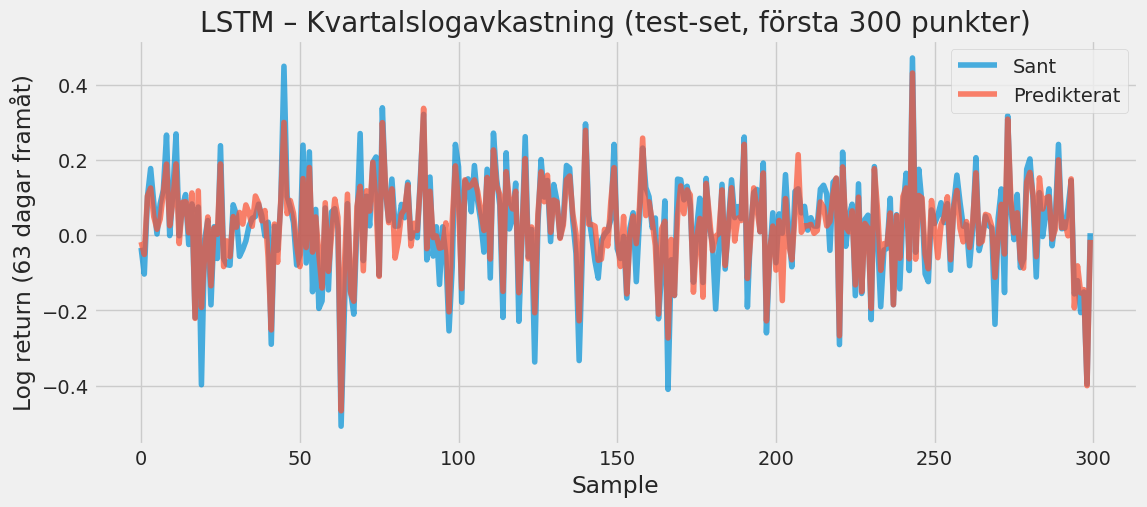

In [31]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")
# Prediktioner
y_pred = model.predict(X_test)

plt.figure(figsize=(12,5))
plt.plot(y_test[:300], label="Sant", alpha=0.7)
plt.plot(y_pred[:300], label="Predikterat", alpha=0.7)
plt.title("LSTM – Kvartalslogavkastning (test-set, första 300 punkter)")
plt.xlabel("Sample")
plt.ylabel("Log return (63 dagar framåt)")
plt.legend()
plt.show()
